<a href="https://colab.research.google.com/github/mahamostaf/Machine-Learning/blob/master/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Head Pose Estimation**

In [1]:
%%capture
!pip install mediapipe

## **Required Libraries**

In [2]:
import numpy as np
import os, cv2, math, glob, random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from google.colab import files

## **Downloading Data**



In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [4]:
mat_file = sio.loadmat('AFLW2000/image00013.mat')
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:26 2016',
 '__version__': '1.0',
 '__globals__': [],
 'pt2d': array([[136.67839196, 164.5678392 , 189.44221106, 229.3919598 ,
         260.29648241, 281.40201005, 158.53768844, 176.6281407 ,
         197.55994818, 242.13048764, 257.70853045, 277.18110695,
         135.24777697, 203.61807082, 217.89799707, 249.05408267,
         322.18429059, 210.54773869, 235.42211055, 257.28140704,
         244.72681277],
        [216.57788945, 207.53266332, 207.53266332, 191.70351759,
         182.65829146, 182.65829146, 231.65326633, 228.63819095,
         230.03871776, 217.05700009, 208.40250631, 209.26797869,
         293.64905153, 281.53280624, 263.79112849, 268.55108857,
         252.97304577, 318.33668342, 312.30653266, 308.53768844,
         377.59738819]]),
 'Illum_Para': array([[ 0.92531824,  0.85142124,  0.84738654,  0.55454063,  0.63420337,
          0.66929287,  0.07650548,  1.24921274,  0.02066589, 20. 

In [5]:
ls

AFLW2000/  AFLW2000-3D.zip  sample_data/


In [6]:
x_point = []
y_point = []
labels = []
images = []

face_mesh = mediapipe.solutions.face_mesh
files = sorted([Path(img).stem for img in glob.glob("AFLW2000/*.mat")])

for img_file in files:
  with face_mesh.FaceMesh(static_image_mode=True) as faces:
    img = cv2.imread('AFLW2000/'+ img_file +'.jpg')

    results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      images.append(img_file)
      x = []
      y = []
      face = results.multi_face_landmarks[0]
      for landmark in face.landmark:

        x_ = int(landmark.x * img.shape[1])
        y_ = int(landmark.y * img.shape[0])

        x.append(x_)
        y.append(y_)

      x_point.append(x)
      y_point.append(y)

      params = sio.loadmat(f'AFLW2000/{img_file}.mat')
      pitch_yaw_roll = params['Pose_Para'][0][0:3]
      labels.append(pitch_yaw_roll)

labels = np.array(labels)
x_point = np.array(x_point)
y_point = np.array(y_point)

In [7]:
labels.shape

(1853, 3)

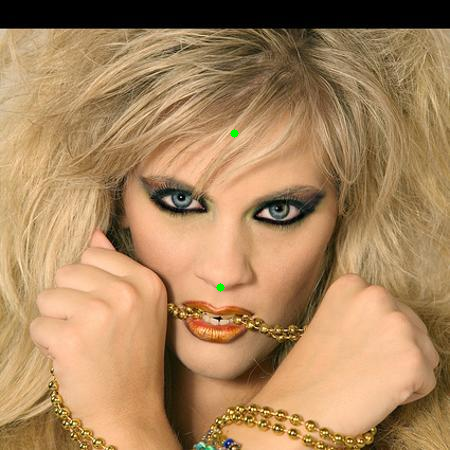

In [8]:
img = cv2.imread('AFLW2000/image00002.jpg')
cv2.circle(img, (x_point[0][1], y_point[0][1]), radius=1, color=(0, 255, 0), thickness=5)
cv2.circle(img, (x_point[0][10], y_point[0][10]), radius=1, color=(0, 255, 0), thickness=5)
cv2_imshow(img)

In [9]:
x_point[:, 1].shape, x_point.shape

((1853,), (1853, 468))

## **Data Preproccessing**

**Solving The Problem of Face Location In Image(Faces are in different locations in images)**
- By setting one point (nose point) as reference point for all face points. </br>

**Solving The Problem of Face Size(Faces are different sizes)**
- Dividing face points by faces size(Distance between nose and chain for example).


In [10]:
# Face Location
x_points = x_point - x_point[:, 1].reshape(-1, 1)
y_points = y_point - y_point[:, 1].reshape(-1, 1)

# Face Size
a = np.array((x_point[:, 10], y_point[:, 10]))
b = np.array((x_point[:, 1], y_point[:, 1]))
forehead_nose_dist = np.linalg.norm(a - b)

x_points = x_points / forehead_nose_dist
y_points = y_points / forehead_nose_dist

X = pd.DataFrame(np.hstack([x_points, y_points]))

## **Data Preparation**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X.shape

(1853, 936)

In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-0.000371,0.0,0.000000,-0.000927,0.000000,0.000371,0.001113,-0.010571,0.001484,0.001669,...,0.000185,-0.000371,-0.000185,0.000371,0.000556,-0.012797,-0.012240,-0.011498,-0.013909,-0.014651
1,0.002040,0.0,0.002596,0.001669,0.000000,0.000927,0.003895,0.003895,0.004822,0.004636,...,0.000556,0.000371,0.001484,0.000742,0.001113,-0.007047,-0.006676,-0.006491,-0.007604,-0.008160
2,-0.000185,0.0,-0.000185,-0.000927,0.000000,0.000000,-0.000371,-0.006120,-0.000556,-0.000556,...,0.000000,-0.000185,-0.000185,0.000185,0.000185,-0.004822,-0.004636,-0.004451,-0.005378,-0.005564
3,0.002782,0.0,0.001669,-0.002225,-0.000742,-0.001113,-0.001484,-0.009087,-0.002782,-0.003524,...,-0.000556,-0.001298,-0.001855,-0.000185,-0.000185,-0.012797,-0.012055,-0.011313,-0.016506,-0.017433
4,0.001484,0.0,0.000556,-0.002040,-0.000371,-0.000742,-0.001484,-0.011127,-0.002040,-0.002411,...,0.000185,-0.000556,0.000185,0.000371,0.000742,-0.010386,-0.009829,-0.009458,-0.012797,-0.013168


In [14]:
x_train, x_val, y_train, y_val, train_images, val_images = train_test_split(X, labels, images, test_size = 0.2, random_state=0)

In [15]:
len(train_images), len(x_train)

(1482, 1482)

In [16]:
len(val_images), len(x_val)

(371, 371)

In [17]:
y_train.shape, y_val.shape

((1482, 3), (371, 3))

## **Model Selection**

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

### **Linear Regression**

In [19]:
lr = LinearRegression().fit(x_train, y_train)

y_predict = lr.predict(x_val)

In [20]:
print("Training Accuracy: ", lr.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.8723943391533178
Testing Accuracy:  0.04011171391120175


### **Ridge**

In [21]:
r = Ridge().fit(x_train, y_train)

y_predict = r.predict(x_val)

In [22]:
print("Training Accuracy: ", r.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.4645981553217413
Testing Accuracy:  0.33176808165813565


### **Lasso**

In [23]:
l = Lasso().fit(x_train, y_train)

y_predict = l.predict(x_val)

In [24]:
print("Training Accuracy: ", l.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.0
Testing Accuracy:  -0.0037123743129295526


### **Support Vector Machine (SVM)**

    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']

In [25]:
svr = MultiOutputRegressor(SVR()).fit(x_train, y_train)

y_predict = svr.predict(x_val)

In [26]:
print("Training Accuracy: ", svr.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.5270294229238244
Testing Accuracy:  0.3719228476298501


### **Adaptive Boost Regressor (AdaBoost)**

    'n_estimators': [50, 100],
    'learning_rate' : [0.01,0.05,0.1,0.3,1],
    'loss' : ['linear', 'square', 'exponential']

In [27]:
ab = MultiOutputRegressor(AdaBoostRegressor(learning_rate=0.1, loss='square')).fit(x_train, y_train)

y_predict = ab.predict(x_val)

In [28]:
print("Training Accuracy: ", ab.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.849283225330959
Testing Accuracy:  0.3123754377326421


### **XGBRegressor**

    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]

In [29]:
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, subsample=0.5).fit(x_train, y_train)

y_predict = xgb.predict(x_val)

In [30]:
print("Training Accuracy: ", xgb.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.9647391767007347
Testing Accuracy:  0.33210633723003685


### **K Nearest Neighbors Regressor (KNN)**

In [31]:
knn = KNeighborsRegressor().fit(x_train, y_train)

y_predict = knn.predict(x_val)

In [32]:
print("Training Accuracy: ", knn.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.6233931335250836
Testing Accuracy:  0.27788932557762985


### **Decision Tree Regressor**

    'criterion':['gini','entropy'],
    'max_depth':np.arange(1,21),
    'min_samples_split':np.arange(2,11),
    'max_leaf_nodes':np.arange(3,26)

In [33]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=10).fit(x_train, y_train)

y_predict = dtr.predict(x_val)

In [34]:
print("Training Accuracy: ", dtr.score(x_train, y_train))
print("Testing Accuracy: ", r2_score(y_val, y_predict))

Training Accuracy:  0.9584824290922125
Testing Accuracy:  0.3505633132396322




---



**Conclusion**
* I tried to find the best model with best acurracy in training and testing, and at the same time i tried to do parameter tuning to get more useful accuracy in validation and prevent the overfitting as much as possible.

* From my point of view, Support Vector Machine Regressor (SVR) gave the best acurracy on validation or test data.

* But i didn't depend on SVR until i applied the different models on data from internet (image for person), and I found the best result returned to SVR, then AdaBoost.

* So Finally, i used SVR.

---

## **Testing**

In [35]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

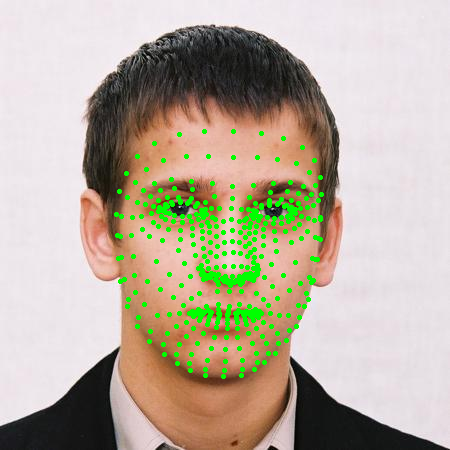

In [36]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+ random_file+ '.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

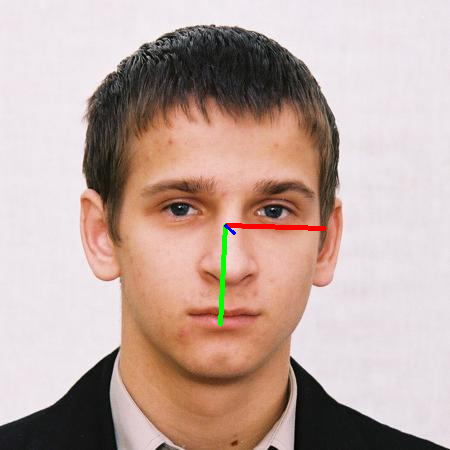

In [37]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch, yaw, roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image, pitch, yaw, roll))

## **Testing On Image**



*   Seen Before



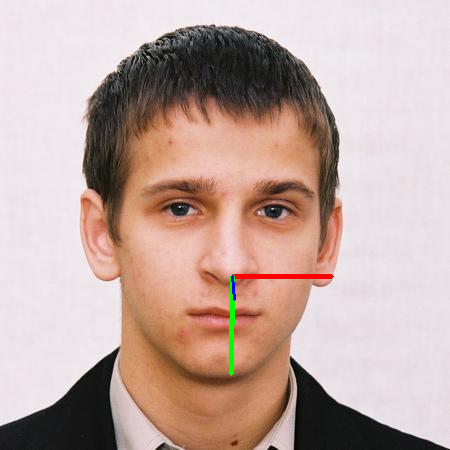

In [39]:
x = []
y = []

face_mesh = mediapipe.solutions.face_mesh

with face_mesh.FaceMesh(static_image_mode=True) as faces:
  img = cv2.imread('AFLW2000/image00053.jpg')

  result = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  if result.multi_face_landmarks != None:
    for face in result.multi_face_landmarks:
      for landmark in face.landmark:

        x_ = int(landmark.x * img.shape[1])
        y_ = int(landmark.y * img.shape[0])

        x.append(x_)
        y.append(y_)

      x = np.array(x)
      y = np.array(y)

      x_norm = x - x[1]
      y_norm = x - x[1]

      a = np.array((x[10], y[10]))
      b = np.array((x[1], y[1]))
      forehead_nose_dist = np.linalg.norm(a - b)

      x_norm = x_norm / forehead_nose_dist
      y_norm = y_norm / forehead_nose_dist

      features = np.hstack([x_norm, y_norm]).reshape(1,-1)

      y_predict = svr.predict(features)

      cv2_imshow(draw_axis(img, y_predict[:, 0], y_predict[:, 1], y_predict[:, 2], x[1], y[1]))



*   First Time To See It.



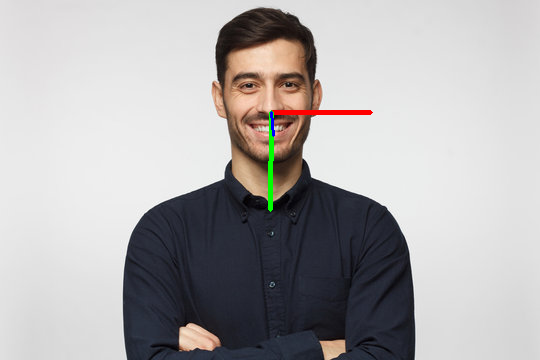

In [40]:
x = []
y = []

face_mesh = mediapipe.solutions.face_mesh

with face_mesh.FaceMesh(static_image_mode=True) as faces:
  img = cv2.imread('img.jpg')

  result = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  if result.multi_face_landmarks != None:
    for face in result.multi_face_landmarks:
      for landmark in face.landmark:

        x_ = int(landmark.x * img.shape[1])
        y_ = int(landmark.y * img.shape[0])

        x.append(x_)
        y.append(y_)

      x = np.array(x)
      y = np.array(y)

      x_norm = x - x[1]
      y_norm = x - x[1]

      a = np.array((x[10], y[10]))
      b = np.array((x[1], y[1]))
      forehead_nose_dist = np.linalg.norm(a - b)

      x_norm = x_norm / forehead_nose_dist
      y_norm = y_norm / forehead_nose_dist

      features = np.hstack([x_norm, y_norm]).reshape(1,-1)

      y_predict = svr.predict(features)

      cv2_imshow(draw_axis(img, y_predict[:, 0], y_predict[:, 1], y_predict[:, 2], x[1], y[1]))

## **Testing On Video**

In [41]:
images = []
cam = cv2.VideoCapture('WIN_20240229_19_18_31_Pro.mp4')
width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

if (cam.isOpened() == False):
    print("Error")

face_mesh = mediapipe.solutions.face_mesh

while(cam.isOpened()):

    ret, img = cam.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:

              x = []
              y = []

              for landmark in face.landmark:

                  x_ = int(landmark.x * img.shape[1])
                  y_ = int(landmark.y * img.shape[0])

                  x.append(x_)
                  y.append(y_)

              x = np.array(x)
              y = np.array(y)

              x_norm = x - x[1]
              y_norm = y - y[1]

              a = np.array((x[10], y[10]))
              b = np.array((x[1], y[1]))
              forehead_nose_dist = np.linalg.norm(a - b)

              x_norm = x_norm / forehead_nose_dist
              y_norm = y_norm / forehead_nose_dist

              features = np.hstack([x_norm, y_norm]).reshape(1,-1)

              y_predict = svr.predict(features)
              draw_axis(img, y_predict[:, 0], y_predict[:, 1], y_predict[:, 2], x[1], y[1])
              images.append(img)
    else:
        break

cam.release()
cv2.destroyAllWindows()

Error


In [ ]:
len(images)

577

In [ ]:
result = cv2.VideoWriter('out_using_svr.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width, height))
for image in images:
    result.write(image)
result.release()

In [ ]:
files.download('out_using_svr.mp4')